# Tracking speed - Benchmarks 2

In this experiment, we extend the results of the Benchmarks notebook by assessing the performance to track 1D `NumPy` arrays.
we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of arrays
* Size of arrays

Configuration:
* Tracking `Numpy` arrays as values, disabling everything else such as git, code, environment and system stats
* Experiments running/tracking offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs


## Imports and utility functions

In [2]:
%load_ext pyinstrument

In [3]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import matplotlib.pyplot as plt
import mlflow
import mltraq
import neptune
import numpy as np
import pandas as pd
import wandb
from mltraq.utils.plot import bar_plot

In [4]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)

mlflow 2.10.2
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.0
mltraq 0.0.118


In [5]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir` recursively. If it already exists, do nothing.
    """
    makedirs(pathdir, exist_ok=True)

## Test procedure for WandB

In [6]:
def test_wandb(n_values=1, size=1):
    """
    Test Weights & Biases tracking with a specified number of arrays.
    """

    # Required to silence Python output and disable sentry tracking.
    # This must be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    wandb.init(
        project=str(uuid.uuid4()),
        group=str(uuid.uuid4()),
        dir=tmp_dir,
        mode="offline",
    )
    for _ in range(n_values):
        table = wandb.Table(columns=["values"])
        table.add_data(np.zeros(size))
        wandb.log({"table": table})
        # Data is stored as JSON in files named table_something.table.json
    wandb.finish()

In [7]:
%%pyinstrument
test_wandb()


_     ._   __/__   _ _  _  _ _/_   Recorded: 13:21:02  Samples:  183
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.214     CPU time: 0.221
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

2.213 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/1666376201.py:1
`- 2.213 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/725407112.py:1
   |- 1.568 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.002 lock.acquire  <built-in>
   |- 0.618 init  wandb/sdk/wandb_init.py:940
   |     [36 frames hidden]  wandb, <built-in>, jupyter_server, re
   `- 0.027 Run.wrapper  wandb/sdk/wandb_run.py:389
         [9 frames hidden]  wandb

## Test procedure for MLflow

In [25]:
def test_mlflow(n_values=1, size=1):
    """
    Test MLflow tracking with a specified number of arrays.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
    with mlflow.start_run(experiment_id=experiment_id):
        for value_id in range(0, n_values):
            # Datasets don't seem to work, this doesn't result in any tracked data:
            # dataset = mlflow.data.from_numpy(np.zeros(size), source="test") # noqa
            # mlflow.log_input(dataset, context="training")# noqa

            # .log_param has a size limit of 6K
            # .log_metric works only with floats
            # .log_text writes to a file in dir ./mlruns

            # Not optimal, but there doesn't seem to be a better way without first
            # writing it to disk before creating one more copy.
            # large blobs are tacked on the filesystem as artifacts.
            # E.g., ".../artifacts/value_0".

            mlflow.log_text(str(np.zeros(size).tobytes()), f"value_{value_id}")

    mlflow.end_run()
    remove_file(db_fname)

In [27]:
%%pyinstrument
test_mlflow()


_     ._   __/__   _ _  _  _ _/_   Recorded: 13:32:25  Samples:  189
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.718     CPU time: 0.833
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

1.717 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/2371405818.py:1
`- 1.717 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/3410521373.py:1
   |- 1.402 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [17 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        0.815 lock.acquire  <built-in>
   |        0.518 lock.acquire  <built-in>
   |- 0.279 create_experiment  mlflow/tracking/fluent.py:1532
   |     [72 frames hidden]  mlflow, alembic, <string>, sqlalchemy
   `- 0.026 wrapper  comet_ml/monkey_patching.py:261
         [10 frames hidden]  comet_ml, <built-in>

## Test procedure for Neptune

In [10]:
def test_neptune(n_values=1, size=1):
    """
    Test Neptune tracking with a specified number of arrays.
    """

    run = neptune.init_run(
        project=f"workspace/{str(uuid.uuid4())}",
        mode="offline",
        git_ref=False,
    )
    for _ in range(0, n_values):
        # https://docs.neptune.ai/logging/arrays_and_tensors/#logging-numpy-arrays
        run["value"].append(neptune.types.File.as_image(np.zeros((size, 1))))
        # File encoded in string format
    run.wait()
    run.stop()

In [11]:
%%pyinstrument
test_neptune()

[neptune] [info   ] Neptune initialized. Open in the app: offline/443c5231-892a-4294-9b09-ec47355a8db8
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


_     ._   __/__   _ _  _  _ _/_   Recorded: 13:21:06  Samples:  17
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.019     CPU time: 0.015
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

0.018 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/3214493869.py:1
`- 0.018 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/770400714.py:1
   |- 0.011 Run.__init__  neptune/metadata_containers/run.py:307
   |     [57 frames hidden]  neptune, traceback, linecache, tokeni...
   |- 0.004 as_image  neptune/types/atoms/file.py:173
   |     [12 frames hidden]  neptune, PIL, <built-in>
   |- 0.002 Run.stop  neptune/metadata_containers/metadata_container.py:410
   |     [15 frames hidden]  neptune, logging, ipykernel, threading
   `- 0.001 Handler.inner_fun  neptune/handler.py:85
         [10 frames hidden]  neptune, typing, <frozen abc>

## Test procedure for Aim

In [12]:
def test_aim(n_values=1, size=1):
    """
    Test Aim tracking with a specified number of arrays.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
    # Experiments in Aim match to what we call runs in this notebook.
    run = aim.Run(
        repo=repo,
        experiment=str(uuid.uuid4()),
        system_tracking_interval=None,
        capture_terminal_logs=False,
    )
    for _ in range(0, n_values):
        # With:
        #    run.track({"value": [np.zeros(size)]}) # noqa
        # Error:
        #    TypeError: Unhandled non-native value `[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]`
        #    of type `<class 'numpy.ndarray'>`.
        run.track({"value": [np.zeros(size).tobytes()]})

In [13]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 13:21:06  Samples:  30
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.818     CPU time: 0.042
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

0.818 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/3340399674.py:1
|- 0.728 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/309431964.py:1
|  `- 0.728 wrapper  aim/ext/exception_resistant.py:65
|        [30 frames hidden]  aim, subprocess, <built-in>, sqlalchemy
|           0.406 waitpid  <built-in>
`- 0.090 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [14]:
def test_comet(n_values=1, size=1):
    """
    Test Comet tracking with a specified number of arrays.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    run = comet_ml.OfflineExperiment(
        project_name=str(uuid.uuid4()),
        log_code=False,
        log_graph=False,
        log_env_gpu=False,
        log_env_cpu=False,
        log_env_network=False,
        log_env_disk=False,
        log_env_host=False,
        log_git_metadata=False,
        offline_directory=tmp_dir,
        experiment_key=str(uuid.uuid4().hex),
        display_summary_level=0,
    )
    for _ in range(0, n_values):
        # .log_other, .log_metrics don't really track
        # the value, it converts the object to a
        # short string eg. "[0, 0, ...., 0, 0]".
        run.log_text(str(np.zeros(size).tolist()))

    run.end()

In [15]:
%%pyinstrument
test_comet()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Experiment Name is generated at upload time for Offline Experiments unless set explicitly with Experiment.set_name
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload tmp/comet/d8b3e350-863f-4d65-8f21-626204c01918/13f0350c14b445b28dd2643cc88c6f82.zip


_     ._   __/__   _ _  _  _ _/_   Recorded: 13:21:07  Samples:  9
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.065     CPU time: 0.011
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

0.064 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/3382937944.py:1
`- 0.064 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/1822056711.py:1
   |- 0.059 OfflineExperiment.end  comet_ml/experiment.py:686
   |     [25 frames hidden]  comet_ml, <built-in>, logging, ipyker...
   |        0.056 sleep  <built-in>
   |- 0.004 OfflineExperiment.__init__  comet_ml/offline.py:231
   |     [26 frames hidden]  comet_ml, logging, ipykernel, threadi...
   `- 0.001 OfflineExperiment.log_text  comet_ml/experiment.py:2084
         [4 frames hidden]  comet_ml

## Test procedure for MLtraq

In [16]:
def test_mltraq(n_values=1, size=1):
    """
    Test MLtraq tracking with a specified number of arrays.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options().ctx({"tqdm.disable": True}):
        experiment = session.create_experiment()
        with experiment.run() as run:
            run.fields.ds = mltraq.DataStore()
            run.fields.ds.value = []
            for _ in range(0, n_values):
                run.fields.ds.value.append(np.zeros(size))
        experiment.persist()
    experiment.delete()
    remove_file(db_fname)

In [17]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 13:21:07  Samples:  21
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.022     CPU time: 0.022
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-50e01064-c89e-479c-97fa-f81a55d80706.json

0.022 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/2389778167.py:1
`- 0.022 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_36070/303676234.py:1
   |- 0.014 Experiment.persist  mltraq/experiment.py:346
   |  |- 0.005 Experiment.delete  mltraq/experiment.py:379
   |  |  |- 0.002 Query.count  sqlalchemy/orm/query.py:3052
   |  |  |     [50 frames hidden]  sqlalchemy, <built-in>
   |  |  |- 0.002 Database.drop_table  mltraq/storage/database.py:149
   |  |  |  `- 0.002 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |        [32 frames hidden]  sqlalchemy, <string>
   |  |  `- 0.001 Session.query  sqlalchemy/orm/session.py:2876
   |  |        [6 frames hidden]  sqlalchemy
   |  |- 0.004 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.002 Runs.df  mltraq/runs.py:66
   |  |  |  |- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |  |  |  `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |  |        [6 frames hidden]  pandas
   |  |  |  `- 0.001 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |        [5 frames hidden]  pandas
   |  |  |- 0.001 Series.map  pandas/core/series.py:4600
   |  |  |     [3 frames hidden]  pandas
   |  |  |        0.001 map_array  pandas/core/algorithms.py:1667
   |  |  |        `- 0.001 <lambda>  mltraq/storage/serialization.py:129
   |  |  |           `- 0.001 serialize  mltraq/storage/serialization.py:40
   |  |  |              `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:92
   |  |  |                 `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |  |  |                    `- 0.001 DataPakSerializer.encode_magic_key  mltraq/storage/serializers/datapak.py:149
   |  |  |                       `- 0.001 DataStore.to_url  mltraq/storage/datastore.py:19
   |  |  |                          `- 0.001 DataStoreIO.serialize_write  mltraq/storage/datastore.py:73
   |  |  |                             `- 0.001 DataStoreIO.write  mltraq/storage/datastore.py:81
   |  |  |                                `- 0.001 next_uuid  mltraq/storage/database.py:281
   |  |  |                                   `- 0.001 uuid4  uuid.py:721
   |  |  |                                         [2 frames hidden]  uuid
   |  |  `- 0.001 DataFrame.__setitem__  pandas/core/frame.py:4259
   |  |        [6 frames hidden]  pandas, numpy
   |  |- 0.002 Database.pandas_to_sql  mltraq/storage/database.py:107
   |  |  `- 0.002 wrapper  pandas/util/_decorators.py:325
   |  |        [26 frames hidden]  pandas, sqlalchemy, <built-in>
   |  |- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [10 frames hidden]  sqlalchemy, <string>, <built-in>
   |  `- 0.001 Session.add  sqlalchemy/orm/session.py:3388
   |        [9 frames hidden]  sqlalchemy, weakref
   |- 0.006 Experiment.delete  mltraq/experiment.py:379
   |  |- 0.002 Database.drop_table  mltraq/storage/database.py:149
   |  |  `- 0.002 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |        [15 frames hidden]  sqlalchemy, <string>
   |  |- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [10 frames hidden]  sqlalchemy, <string>, <built-in>
   |  |- 0.001 Query.delete  sqlalchemy/orm/query.py:3114
   |  |     [13 frames hidden]  sqlalchemy, typing
   |  |- 0.001 DataStoreIO.delete  mltraq/storage/datastore.py:64
   |  |  `- 0.001 rmtree  shutil.py:690
   |  |        [2 frames hidden]  shutil, <built-in>
   |  `- 0.001 Session.query  sqlalchemy/orm/session.py:2876
   |        [7 frames hidden]  sqlalchemy
   `

## Defining the experiment

In [40]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "MLtraq":
            test_mltraq(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Neptune":
            test_neptune(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "WandB":
            test_wandb(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Aim":
            test_aim(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Comet":
            test_comet(n_values=run.params.n_values, size=run.params.size)
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree(".cometml-runs", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)


def report_results(experiment: mltraq.Experiment, save_svg_to=None):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=[9, 3], nrows=1, ncols=3)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    with mltraq.options().ctx({"matplotlib.style": "seaborn-v0_8-pastel"}):

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of arrays",
            y="duration",
            group="method",
            yerr=True,
            ax=ax1,
            y_label="Duration (s)",
            y_lim={"bottom": 0},
            y_grid=False,
        )

        bar_plot(
            experiment.runs.df(),
            x="size",
            x_label="Size of arrays",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax2,
            y_lim={"bottom": 0},
        )
        ax2.yaxis.label.set_visible(False)

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax3,
            y_lim={"bottom": 0},
        )
        ax3.yaxis.label.set_visible(False)
        ax3.tick_params(axis="x", labelrotation=25)

    if save_svg_to:
        plt.savefig(save_svg_to, bbox_inches="tight", pad_inches=0.1)

    plt.show()

    # Display aggregated results table (duration and multiplier to the best-performing method)
    print("\nAveraged results by method\n")
    df = experiment.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [20]:
# Create an MLtraq session to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks2.db")

### Experiment 1: How long does tracking a 1D NumPy array of length 1M take?

In this experiment, we evaluate the time required to start a new experiment and track a single array of length 1M (default dtype is `numpy.float64`), which is 8M bytes if written to disk.

In [25]:
len(np.zeros(10**6).tobytes())

8000000

  2%|1         | 1/60 [00:01<01:03,  1.07s/it]

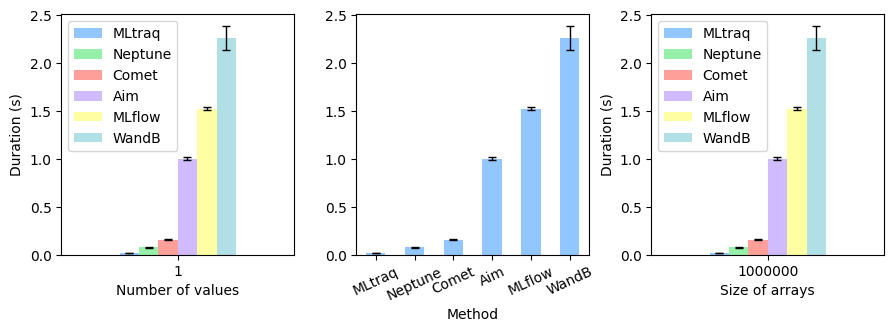


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.022592,1.000000
Neptune,0.082405,3.647581
Comet,0.159102,7.042529
Aim,1.005626,44.513293
MLflow,1.525689,67.533481
WandB,2.267160,100.354118


In [26]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_values=[1],
    size=[int(10**6)],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* Results are very similar to experiment 1 in the Benchmarks notebook. The time cost is dominated by start up (database/filesystem, threads).
* MLtraq is faster than Neptune due to the inefficient serialization strategy of Neptune, that relies on a string format to encode the contents of the array.

### Experiment 2: How much time to track 1, 5, 10 arrays of size 10K, 100K and 1M?

  0%|          | 1/540 [00:00<00:49, 11.00it/s]

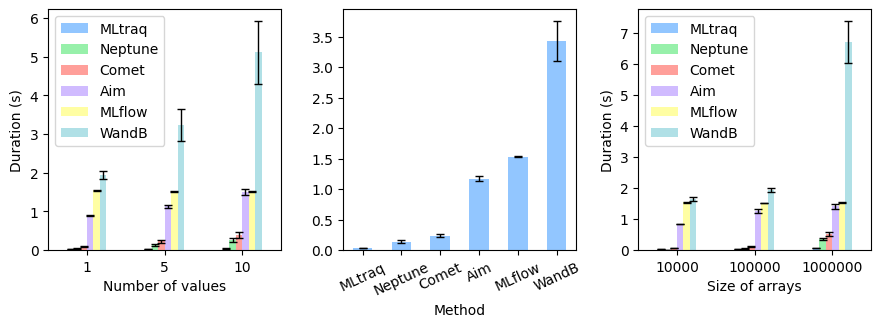


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.032013,1.000000
Neptune,0.137206,4.285890
Comet,0.237191,7.409123
Aim,1.172532,36.626298
MLflow,1.527964,47.728876
WandB,3.428301,107.089573


In [28]:
e = session.create_experiment("exp-2", if_exists="replace")
e.add_runs(
    method=["Aim", "Comet", "Neptune", "MLtraq", "MLflow", "WandB"],
    i=range(10),
    n_values=[1, 5, 10],
    size=[int(10**4), int(10**5), int(10**6)],
)

# WandB not robust, it might fail with "ValueError: I/O operation on closed file.",
# "BrokenPipeError: [Errno 32] Broken pipe" errors.

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* WandB is performing poorly, incurring in the high threading communication cost and the JSON-based serialization to text files.
* MLflow and Aim follow with similar performance, despite working rather differently: MLflow stores large blobs as artifacts on the filesystem, while Aim stores everything in its embedded RocksDB.
* The third cluster includes Comet, Neptune and MLtraq. MLtraq is the best performing method, 4x faster than Neptune. Its DataStore interface is specifically designed to handle efficiently the serialization/storage of large, complex Python objects such as lists, `NumPy` arrays to disk.

### Experiment 3: How much time to track 1, 10, 100, 1K and 10K arrays of size 1K?

  0%|          | 1/450 [00:00<00:32, 13.75it/s]

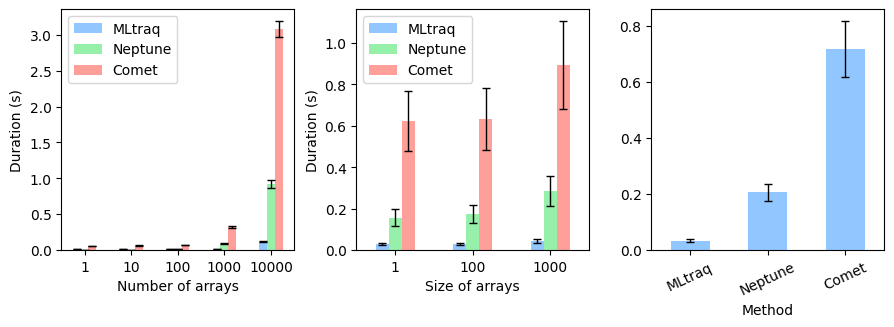


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.033770,1.000000
Neptune,0.205177,6.075658
Comet,0.717608,21.249663


In [36]:
e = session.create_experiment("exp-3", if_exists="replace")
e.add_runs(
    method=["Neptune", "MLtraq", "Comet"],
    i=range(10),
    n_values=[1, int(10**1), int(10**2), int(10**3), int(10**4)],
    size=[1, int(10**2), int(10**3)],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* MLtraq is 6x faster than Neptune and 20x faster than Comet. Its strategy to create a bag of objects that are stored together is much more efficient than storing each object independently, especially if the number of objects is high.

### Aggregates

In [38]:
dfs = [session.load(f"exp-{idx}").runs.df() for idx in [1, 2, 3]]
df = pd.concat(dfs).groupby("method").duration.mean().sort_values().to_frame()
df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
df

,duration,ratio_to_best
method,,
MLtraq,0.032691,1.000000
Neptune,0.175796,5.377571
Comet,0.522318,15.977570
Aim,1.155842,35.356924
MLflow,1.527736,46.733086
WandB,3.312187,101.319019


### Save plots to SVG files

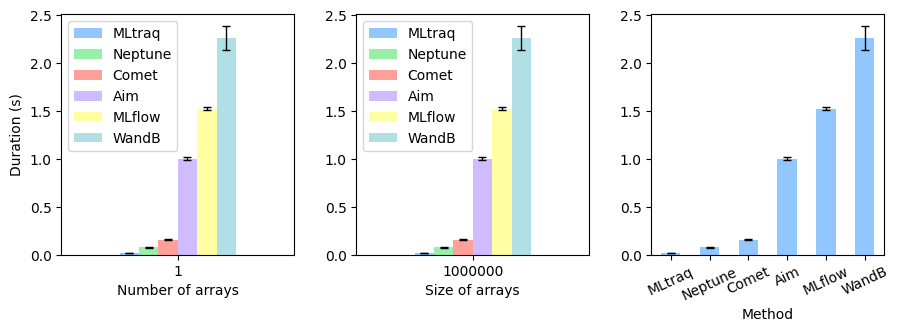


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.022592,1.000000
Neptune,0.082405,3.647581
Comet,0.159102,7.042529
Aim,1.005626,44.513293
MLflow,1.525689,67.533481
WandB,2.267160,100.354118


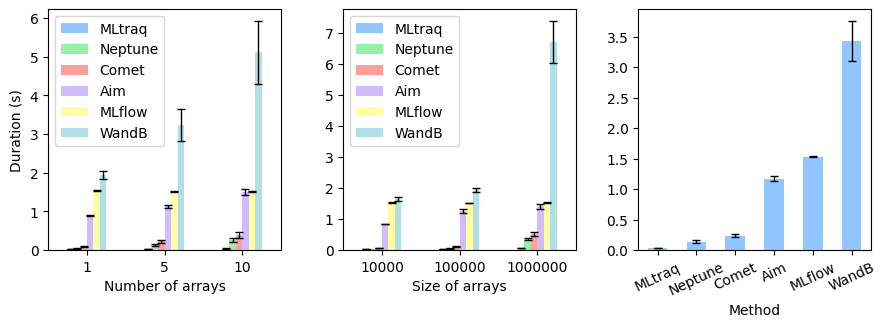


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.032013,1.000000
Neptune,0.137206,4.285890
Comet,0.237191,7.409123
Aim,1.172532,36.626298
MLflow,1.527964,47.728876
WandB,3.428301,107.089573


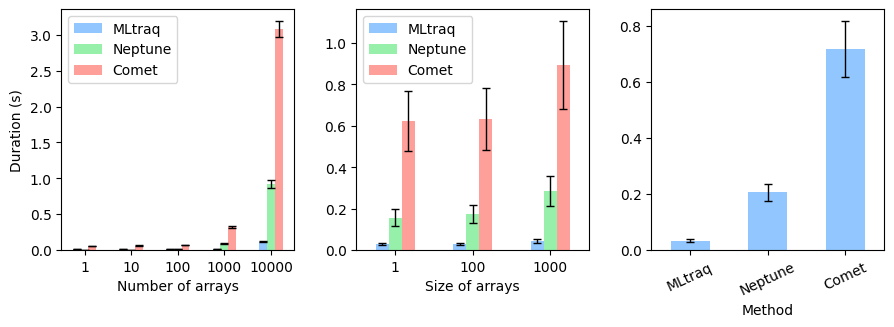


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.033770,1.000000
Neptune,0.205177,6.075658
Comet,0.717608,21.249663


In [41]:
# Create an MLtraq session to reload the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks2.db")

# Save plots to SVG files
report_results(
    session.load("exp-1"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-1.svg",
)
report_results(
    session.load("exp-2"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-2.svg",
)
report_results(
    session.load("exp-3"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-3.svg",
)

## Conclusion

In the experiments, MLtraq is, on average, 4-100x faster than the other methods. As the number and size of the tracked arrays increases, MLtraq stands out even more, being 20x faster than others. MLtraq has been designed to have a robust and complete serialization/storage mechanism for complex Python objects. If tracking a wide range of objects and speed are your priorities, you should consider MLtraq to run your experiments.